In [1]:
import os
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

# Camera Calibration

Get calibration parameters (dist, mtx)

In [2]:
calibration_pickle_files = "camera_cal.p"
calibration_img_path = "camera_cal"

In [3]:
def get_and_store_calibration_file(calibration_img_path, 
                                   filetype="jpg", 
                                   chessboard_size=(9,6),
                                   saveParam=True,
                                   savePath=calibration_pickle_files):
    w, h = chessboard_size
    color_channel = 3
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((h*w, color_channel), np.float32)
    objp[:,:2] = np.mgrid[0:w, 0:h].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob("{0}/*.{1}".format(calibration_img_path, filetype))
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                       imgpoints, 
                                                       img_size, None, None)
    
    if saveParam:
        # Save the useful camera calibration result for later use
        dist_pickle = {}
        dist_pickle["dist"] = dist
        dist_pickle["mtx"] = mtx
        pickle.dump(dist_pickle, open(savePath, "wb"))
    
    return dist_pickle

In [4]:
cal_parm = {}
if calibration_pickle_files not in os.listdir("."):
    cal_parm = get_and_store_calibration_file(calibration_img_path)
else:
    cal_parm = pickle.load(open(calibration_pickle_files, "rb"))

Visualize undistortion technique

In [5]:
def read_img(img_path):
    """Return the img at img_path"""
    return mpimg.imread(img_path)

In [6]:
def undistort(img, cal_parm=cal_parm):
    """Return the undistored img of IMG using CAL_PARM"""
    return cv2.undistort(img, cal_parm["mtx"], 
                            cal_parm["dist"], None, cal_parm["mtx"])

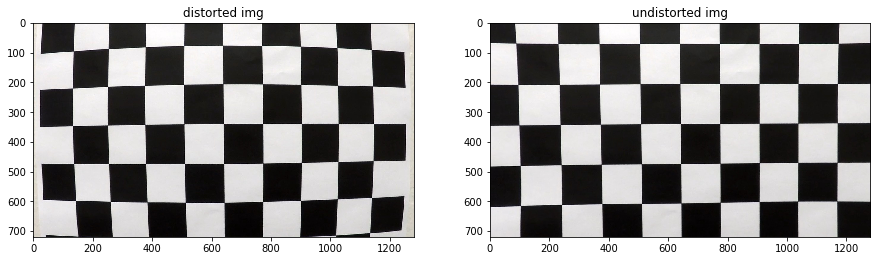

In [7]:
test_distorted_img_path = calibration_img_path + "/calibration1.jpg"
test_distorted_img = read_img(test_distorted_img_path)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.set_title("distorted img")
ax1.imshow(test_distorted_img)

test_undistorted_img = undistort(test_distorted_img)
ax2.set_title("undistorted img")
ax2.imshow(test_undistorted_img)

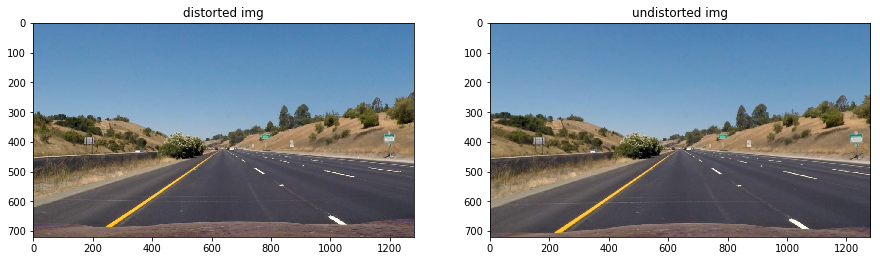

In [8]:
test_distorted_img_path = "test_images/straight_lines1.jpg"
test_distorted_img = read_img(test_distorted_img_path)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.set_title("distorted img")
ax1.imshow(test_distorted_img)

test_undistorted_img = undistort(test_distorted_img)
ax2.set_title("undistorted img")
ax2.imshow(test_undistorted_img)

# Color Thresholding and Edge Detection

In [9]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == "x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

In [10]:
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    # Return the binary image
    return binary_output

In [11]:
def color_thresh(img, sthresh=(0, 255), vthresh=(0, 255), lthresh=(0,255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    # 3) Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    # 4) Apply a threshold to the V channel
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1

    
    # 5) Return a binary image of threshold result
    output = np.zeros_like(s_channel)
    output[( s_binary == 1) & (v_binary == 1)] = 1
    return output

In [12]:
def undist_color_thresh_img(img, sobelx_thresh, sobely_thresh, magthresh, sthresh, vthresh, sobel_kernel=3):
    # Undistor the img
    img = undistort(img)
    
    # Calculate the x and y gradients using Sobel
    sobelx = abs_sobel_thresh(img, orient="x", thresh=sobelx_thresh)
    sobely = abs_sobel_thresh(img, orient="y", thresh=sobely_thresh)
    # Calculate the magnitude gradients using Sobel
    mag = mag_thresh(img, sobel_kernel=sobel_kernel, thresh=magthresh)
    # Calculate color gradients
    color = color_thresh(img, sthresh=sthresh, vthresh=vthresh)
    
    # Combine and output
    output = np.zeros_like(color)
    output[( (sobelx == 1) & (sobely == 1) & (mag == 1))  | (color == 1)] = 1
    
    return output

In [13]:
test_images = [read_img(x) for x in ["test_images/straight_lines1.jpg", 
                                     "test_images/straight_lines2.jpg", 
                                     "test_images/test1.jpg",
                                     "test_images/test2.jpg", 
                                     "test_images/test3.jpg", 
                                     "test_images/test4.jpg", 
                                     "test_images/test5.jpg", 
                                     "test_images/test6.jpg",
                                    "test_images/test7.jpg"]]

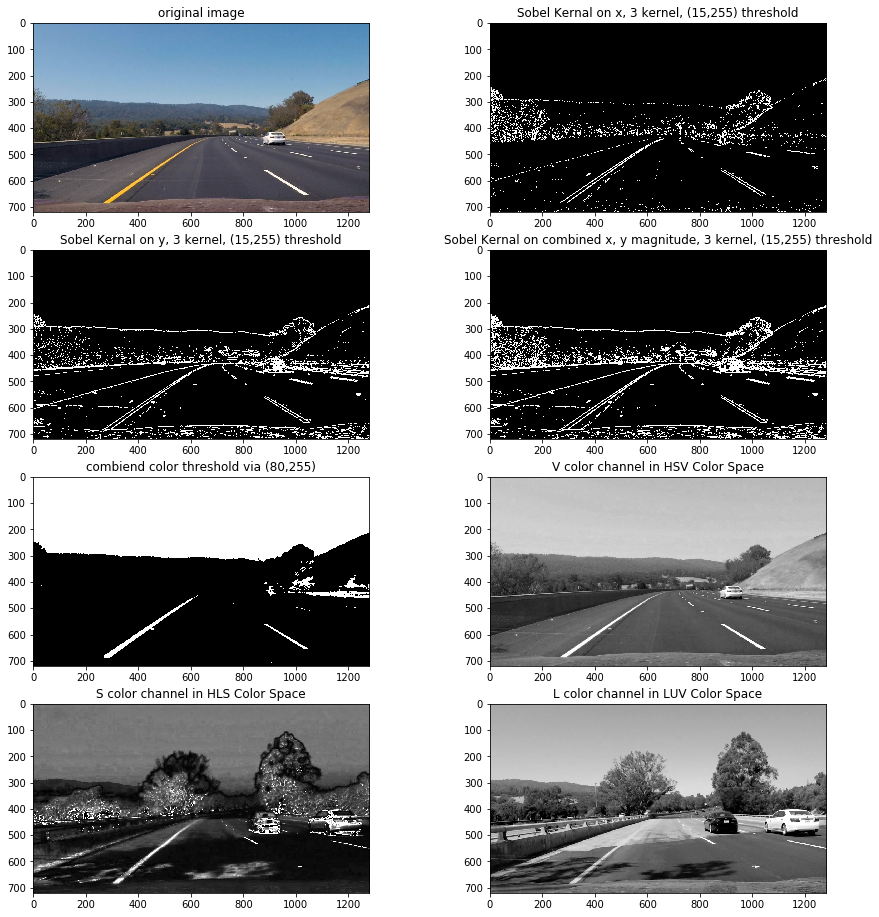

In [14]:
test_img = test_images[4]
fig, axes = plt.subplots(4,2, figsize=(15,16))

axes[0][0].imshow(test_img)
axes[0][0].set_title("original image")

axes[0][1].imshow(abs_sobel_thresh(test_img, orient="x", sobel_kernel=3, thresh=(15,255)), cmap="gray")
axes[0][1].set_title("Sobel Kernal on x, 3 kernel, (15,255) threshold")

axes[1][0].imshow(abs_sobel_thresh(test_img, orient="y", sobel_kernel=3, thresh=(15,255)), cmap="gray")
axes[1][0].set_title("Sobel Kernal on y, 3 kernel, (15,255) threshold")

axes[1][1].imshow(mag_thresh(test_img, sobel_kernel=3, thresh=(15,255)), cmap="gray")
axes[1][1].set_title("Sobel Kernal on combined x, y magnitude, 3 kernel, (15,255) threshold")

axes[2][0].imshow(color_thresh(test_img, (80,255), (80,255)), cmap="gray")
axes[2][0].set_title("combiend color threshold via (80,255)")

axes[2][1].imshow(cv2.cvtColor(test_img, cv2.COLOR_RGB2HSV)[:,:,2], cmap="gray")
axes[2][1].set_title("V color channel in HSV Color Space")

axes[3][0].imshow(cv2.cvtColor(test_images[5], cv2.COLOR_RGB2HLS)[:,:,2], cmap="gray")
axes[3][0].set_title("S color channel in HLS Color Space")

axes[3][1].imshow(cv2.cvtColor(test_images[5], cv2.COLOR_RGB2LUV)[:,:,0], cmap="gray")
axes[3][1].set_title("L color channel in LUV Color Space")

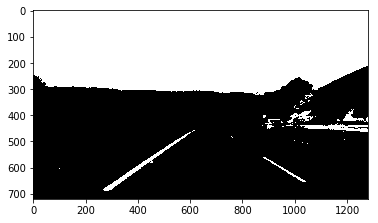

In [15]:
plt.imshow(color_thresh(test_images[4], (80,255), (80,255)), cmap="gray")

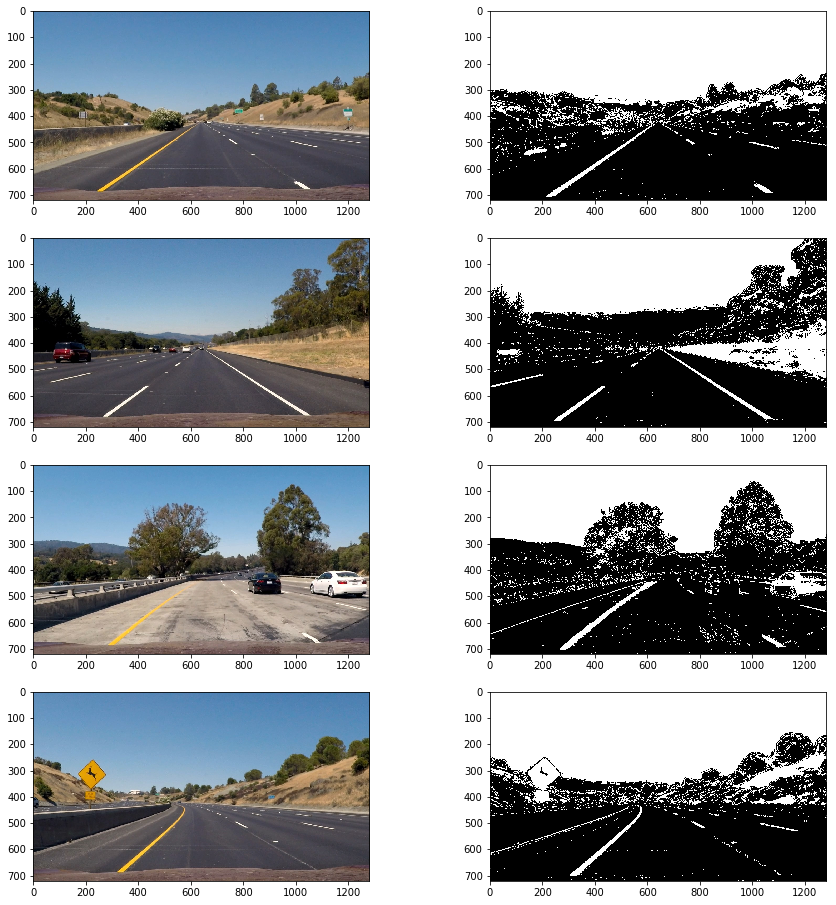

In [16]:
fig, axes = plt.subplots(4, 2, figsize=(15, 16))
sobelx_thresh = (15, 255)
sobely_thresh = (15, 255) 
magthresh = (15,255)
sthresh = (80,255)
vthresh = (80,255)
sobel_kernel = 3

for i, ax in enumerate(axes):
    img = test_images[i]
    ax[0].imshow(img)
    ax[1].imshow(undist_color_thresh_img(img, 
                                        sobelx_thresh=sobelx_thresh, sobely_thresh=sobely_thresh,
                                        magthresh=magthresh,  sthresh=sthresh, vthresh=vthresh, 
                                         sobel_kernel=sobel_kernel), cmap="gray")

# Perspective Transform (Warping)

In [32]:
def unwarp(img):
    src = np.float32([[190,720], [589,457], [698,457], [1145,720]])
    dst = np.float32([[340,720], [340,0], [995,0], [995, 720]])

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR) 
    return warped, M, M_inv

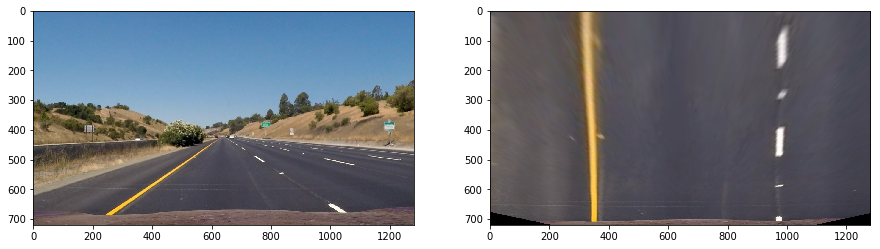

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,10))
test_i = test_images[0]
ax1.imshow(test_i)
ax2.imshow(unwarp(test_i)[0])

# Perspective Transform on Color Threshold Images

In [34]:
def preprocess(img):
    return unwarp(undist_color_thresh_img(img, sobelx_thresh=(15,255), sobely_thresh=(15,255) ,
                                        magthresh=(15,100), sthresh=(80,255) , vthresh=(80,255)))

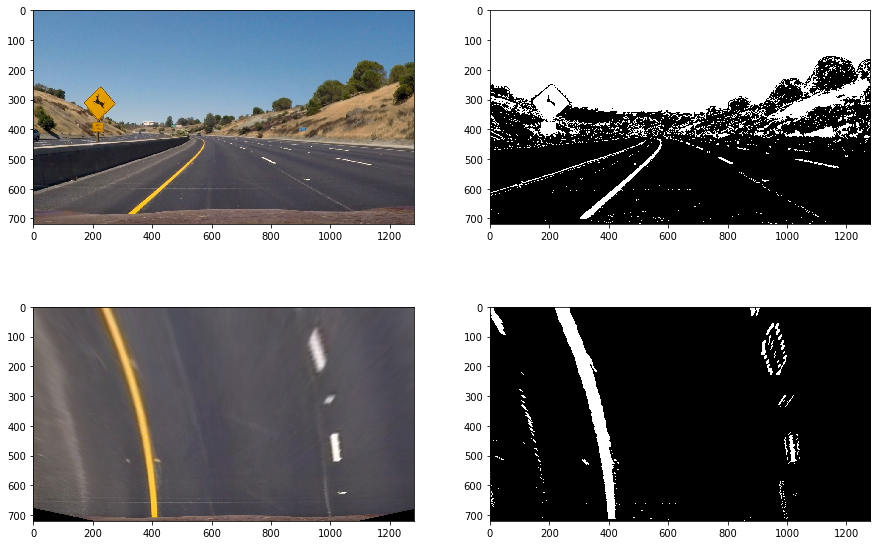

In [35]:
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2,figsize=(15,10))
test_preprocess_img = read_img("test_images/test2.jpg")

ax1.imshow(test_preprocess_img)
ax2.imshow(undist_color_thresh_img(test_preprocess_img, sobelx_thresh=(15,255), sobely_thresh=(15,255) ,
                                        magthresh=(15, 255), sthresh=(80,255) , vthresh=(80,255)), cmap="gray")
ax3.imshow(unwarp(test_preprocess_img)[0], cmap="gray")
ax4.imshow(preprocess(test_preprocess_img)[0], cmap="gray")

# Detect lane line and boundry

In [36]:
def line_fit(binary_warped):
    """
    Find and fit lane lines on binary_warped.

    Return:
    ret['nonzerox'] = x positions of all nonzero pixels in the image
    ret['nonzeroy'] = y positions of all nonzero pixels in the image
    ret['out_img'] = an output image to draw on and visualize the result
    ret['left_fit'] = line fit for left lane line
    ret['left_lane_inds'] = left lane pixel indices
    ret['right_fit'] = line fit for right lane line
    ret['right_lane_inds'] = right lane pixel indices
    """

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ret = {}
    ret['left_fit'] = left_fit
    ret['right_fit'] = right_fit
    ret['leftx'] = leftx
    ret['lefty'] = lefty
    ret['rightx'] = rightx
    ret['righty'] = righty
    return ret

In [37]:
def visualize_line(binary_warped, ret, ax=plt):
    left_fit = ret['left_fit']
    right_fit = ret['right_fit']
    leftx = ret['leftx']
    lefty = ret['lefty']
    rightx = ret['rightx']
    righty = ret['righty']

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    out_img[lefty, leftx] = [255, 0, 0] # red
    out_img[righty, rightx] = [0, 0, 255] # blue
    ax.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [38]:
def measure_curvature(binary_warped, ret):
    """"
    Calculate radius of curvature in meters
    """
    left_fit = ret['left_fit']
    right_fit = ret['right_fit']
    leftx = ret['leftx']
    lefty = ret['lefty']
    rightx = ret['rightx']
    righty = ret['righty']

    y_eval = binary_warped.shape[0] - 1

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    #right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad#, right_curverad

curvature 852.252248168


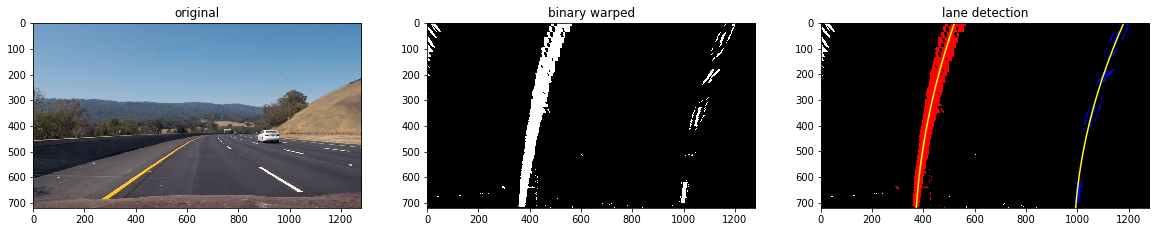

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,10))
test_img = read_img("test_images/test3.jpg")

binary_warped = preprocess(test_img)[0]
ret = line_fit(binary_warped)

ax1.imshow(test_img)
ax1.set_title("original")
ax2.imshow(binary_warped, cmap="gray")
ax2.set_title("binary warped")
visualize_line(binary_warped, ret, ax3)
ax3.set_title("lane detection")
print("curvature", measure_curvature(binary_warped, ret))

# Fill Lane 

In [49]:
def fill_lane(img):
    binary_warped, M, M_inv = preprocess(img)
    
    ret = line_fit(binary_warped)
    
    left_fit = ret['left_fit']
    right_fit = ret['right_fit']
    leftx = ret['leftx']
    lefty = ret['lefty']
    rightx = ret['rightx']
    righty = ret['righty']
    
    yvals = np.arange(0, binary_warped.shape[0])
    
    left_fitx = np.array(left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2], np.int32)
    right_fitx = np.array(right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2], np.int32)
    
    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img) # used to remove white space on red/blue line marked over
    road_inner = np.zeros_like(img) # green middle lane
    
    lane_width = 20
    left_lane = np.array(list(zip(np.concatenate([left_fitx-lane_width/2, left_fitx[::-1]+lane_width/2], axis=0),
                                 np.concatenate([yvals, yvals[::-1]], axis=0))), np.int32)
    right_lane = np.array(list(zip(np.concatenate([right_fitx-lane_width/2, right_fitx[::-1]+lane_width/2], axis=0),
                                 np.concatenate([yvals, yvals[::-1]], axis=0))), np.int32)
    inner_lane = np.array(list(zip(np.concatenate([left_fitx+lane_width/2, right_fitx[::-1]-lane_width/2], axis=0),
                                 np.concatenate([yvals, yvals[::-1]], axis=0))), np.int32)
    
    cv2.fillPoly(road, [left_lane], color=[255,0,0])
    cv2.fillPoly(road, [right_lane], color=[0,0,255])
    cv2.fillPoly(road_inner, [inner_lane], color=[0,255,0])
    cv2.fillPoly(road_bkg, [left_lane], color=[255,255,255])
    cv2.fillPoly(road_bkg, [right_lane], color=[255,255,255])
    
    img_size = (img.shape[1], img.shape[0])
    road_warped = cv2.warpPerspective(road, M_inv, img_size, flags=cv2.INTER_LINEAR)
    road_bkg_warped = cv2.warpPerspective(road_bkg, M_inv, img_size, flags=cv2.INTER_LINEAR)
    road_inner_warped = cv2.warpPerspective(road_inner, M_inv, img_size, flags=cv2.INTER_LINEAR)
    
    result = cv2.addWeighted(img, 1.0, road_bkg_warped, -1.0, 0.0)
    result = cv2.addWeighted(result, 1.0, road_warped, 1.0, 0.0)
    result = cv2.addWeighted(result, 1.0, road_inner_warped, 0.5, 0.0)
    
    
    cur = measure_curvature(binary_warped, ret)
    
    cv2.putText(result, 'Radius of curvature: {0:.3f}m'.format(cur), (50,50), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2)
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_diff = ((np.median(right_fitx)- np.median(left_fitx))/2.0 - img.shape[0]/2.0)*xm_per_pix
    if center_diff < 0:
        cv2.putText(result, 'Vehicle is {0:.3f}m left of center'.format(np.abs(center_diff)), (50,100), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2)
    else:
        cv2.putText(result, 'Vehicle is {0:.3f}m right of center'.format(np.abs(center_diff)), (50,100), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2)
        
    return result

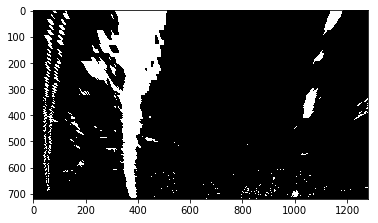

In [51]:
plt.imshow(preprocess(test_images[2])[0], cmap="gray")

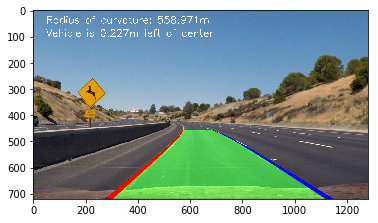

In [56]:
plt.imshow(fill_lane(test_images[3]))

# Process Video

In [57]:
source_videos = ["project_video.mp4", "challenge_video.mp4", "harder_challenge_video.mp4"]

In [58]:
from collections import deque
# Define a class to receive the characteristics of each line detection
class Tracker():
    def __init__(self, smooth_factor=5):
        #polynomial coefficients for the fit over past n timestamps
        self.best_fit_left = np.zeros(3)
        self.best_fit_right = np.zeros(3)
        #radius of curvature of the line in some units
        self.radius_of_curvature = None  
        #x values for detected line pixels
        self.allx_left = deque(maxlen=smooth_factor)  
        self.allx_right = deque(maxlen=smooth_factor)    
        #y values for detected line pixels
        self.ally_left = deque(maxlen=smooth_factor)  
        self.ally_right = deque(maxlen=smooth_factor)  
        self.smooth_factor = smooth_factor
    
    def line_fit(self, binary_warped):
        """
        Find and fit lane lines on binary_warped.

        Return:
        ret['nonzerox'] = x positions of all nonzero pixels in the image
        ret['nonzeroy'] = y positions of all nonzero pixels in the image
        ret['out_img'] = an output image to draw on and visualize the result
        ret['left_fit'] = line fit for left lane line
        ret['left_lane_inds'] = left lane pixel indices
        ret['right_fit'] = line fit for right lane line
        ret['right_lane_inds'] = right lane pixel indices
        """

        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 3) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        def get_average(lst):
            flattened = np.concatenate(lst)
            factor = min(self.smooth_factor, len(lst))
            flattened = flattened[:len(flattened)//factor*factor]
            return np.average(flattened.reshape([factor,-1]), axis=0)

        # Extract left and right line pixel positions
        if len(nonzerox[left_lane_inds]) > 0:
            self.allx_left.append(nonzerox[left_lane_inds])
            self.ally_left.append(nonzeroy[left_lane_inds])
            leftx = get_average(self.allx_left)
            lefty =  get_average(self.ally_left)
        if len(nonzerox[right_lane_inds]) > 0:
            self.allx_right.append(nonzerox[right_lane_inds])
            self.ally_right.append(nonzeroy[right_lane_inds])
            rightx = get_average(self.allx_right)
            righty = get_average(self.ally_right)

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        self.best_fit_left = left_fit
        self.best_fit_right = right_fit

        ret = {}
        ret['left_fit'] = left_fit
        ret['right_fit'] = right_fit
        ret['leftx'] = leftx
        ret['lefty'] = lefty
        ret['rightx'] = rightx
        ret['righty'] = righty
        return ret

    def fill_lane(self, img):
        binary_warped, M, M_inv = preprocess(img)

        ret = self.line_fit(binary_warped)        
        left_fit = ret['left_fit']
        right_fit = ret['right_fit']
        leftx = ret['leftx']
        lefty = ret['lefty']
        rightx = ret['rightx']
        righty = ret['righty']

        yvals = np.arange(0, binary_warped.shape[0])

        left_fitx = np.array(left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2], np.int32)
        right_fitx = np.array(right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2], np.int32)

        road = np.zeros_like(img)
        road_bkg = np.zeros_like(img) # used to remove white space on red/blue line marked over
        road_inner = np.zeros_like(img) # green middle lane

        lane_width = 20
        left_lane = np.array(list(zip(np.concatenate([left_fitx-lane_width/2, left_fitx[::-1]+lane_width/2], axis=0),
                                     np.concatenate([yvals, yvals[::-1]], axis=0))), np.int32)
        right_lane = np.array(list(zip(np.concatenate([right_fitx-lane_width/2, right_fitx[::-1]+lane_width/2], axis=0),
                                     np.concatenate([yvals, yvals[::-1]], axis=0))), np.int32)
        inner_lane = np.array(list(zip(np.concatenate([left_fitx+lane_width/2, right_fitx[::-1]-lane_width/2], axis=0),
                                     np.concatenate([yvals, yvals[::-1]], axis=0))), np.int32)

        cv2.fillPoly(road, [left_lane], color=[255,0,0])
        cv2.fillPoly(road, [right_lane], color=[0,0,255])
        cv2.fillPoly(road_inner, [inner_lane], color=[0,255,0])
        cv2.fillPoly(road_bkg, [left_lane], color=[255,255,255])
        cv2.fillPoly(road_bkg, [right_lane], color=[255,255,255])

        img_size = (img.shape[1], img.shape[0])
        road_warped = cv2.warpPerspective(road, M_inv, img_size, flags=cv2.INTER_LINEAR)
        road_bkg_warped = cv2.warpPerspective(road_bkg, M_inv, img_size, flags=cv2.INTER_LINEAR)
        road_inner_warped = cv2.warpPerspective(road_inner, M_inv, img_size, flags=cv2.INTER_LINEAR)

        result = cv2.addWeighted(img, 1.0, road_bkg_warped, -1.0, 0.0)
        result = cv2.addWeighted(result, 1.0, road_warped, 1.0, 0.0)
        result = cv2.addWeighted(result, 1.0, road_inner_warped, 0.5, 0.0)


        cur = measure_curvature(binary_warped, ret)
        self.radius_of_curvature = cur

        cv2.putText(result, 'Radius of curvature: {0:.3f}m'.format(cur), (50,50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2)

        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        center_diff = ((np.median(right_fitx)- np.median(left_fitx))/2.0 - img.shape[0]/2.0)*xm_per_pix
        if center_diff < 0:
            cv2.putText(result, 'Vehicle is {0:.3f}m left of center'.format(np.abs(center_diff)), (50,100), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2)
        else:
            cv2.putText(result, 'Vehicle is {0:.3f}m right of center'.format(np.abs(center_diff)), (50,100), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2)

        return result
    


In [59]:
tracker = Tracker(smooth_factor=10)
def process_vid(img):
    if img is not None:
        return fill_lane(img) 
    return img

In [60]:
video_output = 'project_result.mp4'
clip1 = VideoFileClip(source_videos[0])
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_result.mp4
[MoviePy] Writing video project_result.mp4


100%|█████████▉| 1260/1261 [03:48<00:00,  5.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_result.mp4 



In [61]:
video_output = 'challenge_result.mp4'
clip1 = VideoFileClip(source_videos[1])
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_result.mp4
[MoviePy] Writing video challenge_result.mp4


100%|██████████| 485/485 [01:30<00:00,  3.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_result.mp4 



In [62]:
video_output = 'harder_challenge_video_result.mp4'
clip1 = VideoFileClip(source_videos[2])
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_result.mp4
[MoviePy] Writing video harder_challenge_video_result.mp4


100%|█████████▉| 1199/1200 [04:45<00:00,  5.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_result.mp4 

